In [1]:
import json, csv, os, ast
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import scipy as sp
from IPython.display import display, HTML
import xml.etree.ElementTree
import seaborn as sns
import pylab as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

sns.set_style('whitegrid')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
gold_dict = ['HIGH', 'LOW']

In [61]:
import itertools
import numpy as np

# scores 1 is the ground truth
def my_pairw(scores1, scores2, which_group = 'first', agr_comparison='<', removeties=False):
    uguals = 0
    if which_group=='second':
        scores1, scores2 = scores2, scores1
    
    assert len(scores1) == len(scores2), 'Error on lenghts'
    
    if len(np.unique(scores1))==1:
        return 1
    
    scores1, scores2 = (list(t) for t in zip(*sorted(zip(scores1, scores2)))) 
    groups = np.unique(scores1)
    lst_groups = [np.array([]) for i in range(len(groups))]
    dict_group = {}
    for i in range(len(groups)):
        dict_group[groups[i]] = i
    for i in range(len(scores1)):    
        lst_groups[dict_group[scores1[i]]] = np.append( lst_groups[dict_group[scores1[i]]], scores2[i])        
    groups_to_check  = list(  itertools.combinations(range(len(lst_groups)), 2)  )
    list_couples =  [ list(itertools.product(lst_groups[j[0]], lst_groups[j[1]])) for j in groups_to_check ] 
    list_couples = [item for sublist in list_couples for item in sublist]
    agreement_couple = 0
    possible_couples = len(list_couples)
    
    less_than_cuples = 0
    less_than_equal_cuples = 0
    equal_cuples = 0
    
    for k in list_couples:        
        if k[0] < k[1]:
            less_than_cuples +=1
            less_than_equal_cuples +=1
        elif k[0] <= k[1]:
            less_than_equal_cuples +=1
            equal_cuples +=1
        else:
            pass
    
    
          
    if (agr_comparison == "<") & (removeties==True):
        return float( (less_than_cuples)/(possible_couples-equal_cuples) )
    if (agr_comparison == "<") & (removeties==False):
        return float( (less_than_cuples)/(possible_couples) ) 
    if (agr_comparison == "<=") & (removeties==True):
        return float( (less_than_equal_cuples-equal_cuples)/(possible_couples-equal_cuples) ) 
    if (agr_comparison == "<=") & (removeties==False):
        return float( (less_than_equal_cuples)/(possible_couples) )  
    
    assert False
    return -1

In [62]:
df_agreement = pd.DataFrame(columns=['unit', 'dataset', 'filtering', 'agr_measure', 'agr_score'])

dataset = "S100"
doc_rel = '{}_rel'.format(dataset)

df = pd.read_csv('../../Task/BigTask/Parsed-results_S100.csv')
#df = df[df["doc_id"].isin(gold_dict.values()) == False]
df100 = df[['unit_id', 'position_in_task', 'doc_id', "S100_rel", 'rel']]
#df100 = df100.rename(columns={"judgments": "S100_rel"})

dataset = 'S6'
doc_rel = '{}_rel'.format(dataset)

df = pd.read_csv('../../Task/BigTask/Parsed-results_S6.csv')
#df = df[df["doc_id"].isin(gold_dict.values()) == False]
df6 = df[['unit_id', 'position_in_task', 'doc_id', 'S6_rel']]
#df6 = df6.rename(columns={"judgments": "S6_rel"})

merged = df100.merge(df6, how = 'left', on = ['unit_id', 'position_in_task', 'doc_id'])

#merged = merged[merged[filtering]>=0]

#display(merged.head(2))
############################################

units = np.unique(merged['unit_id'].values)
display(merged.head())

for dataset_to_agreement in ['S100_rel', 'S6_rel']:
    for i_u, unit in enumerate(units): #   <-- for each unit
        if i_u % 500 == 0: 
            print('{}/{}, '.format(i_u+1-1, len(units)), end='')

        pivoted = merged[merged['unit_id'] == unit]

        agr_ground_truth = pivoted['rel'].values
        agr_data = pivoted[dataset_to_agreement].values

        #display(pivoted.head())
        #print(len(agr_ground_truth))
        #print(len(agr_data))

        agremeent = my_pairw(agr_ground_truth, agr_data, which_group = 'first',
                             agr_comparison='<', removeties=True)
        #print(agremeent)
        #assert False

        #'unit', 'dataset', 'filtering', 'agr_measure', 'agr_score'
        df_agreement.loc[len(df_agreement)] = np.array([unit, dataset_to_agreement, 'rel', 'pair_agree', agremeent])
        #assert False
df_agreement.set_index(['filtering', 'unit'], inplace = True)
display(df_agreement.head())
#display(df_agreement.tail())
#assert False

,unit_id,position_in_task,doc_id,S100_rel,rel,S6_rel
0,unit_0,1,REP_LIE_doc6,3.0,LIE,1
1,unit_0,2,DEM_FALSE_doc1,6.0,FALSE,1
2,unit_0,3,LOW,1.0,LOW,2
3,unit_0,4,DEM_HALFTRUE_doc3,2.0,HALFTRUE,4
4,unit_0,5,DEM_TRUE_doc2,40.0,TRUE,2


0/200, 0/200, 

dataset agr_measure           agr_score
filtering unit                                              
rel       unit_0    S100_rel  pair_agree  0.4642857142857143
          unit_1    S100_rel  pair_agree  0.6153846153846154
          unit_10   S100_rel  pair_agree  0.2857142857142857
          unit_100  S100_rel  pair_agree  0.5416666666666666
          unit_101  S100_rel  pair_agree  0.5555555555555556

c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
c:\users\barbe\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


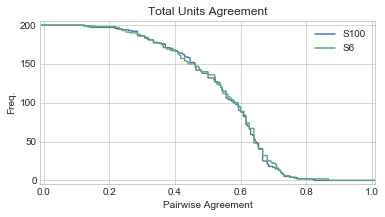

In [63]:
datasets = ['S100_rel', 'S6_rel',]
filters = ['rel']

for filtering in filters :
    df_agreement_spec = df_agreement.loc[filtering]
    
    p_linestyles = ['-', '-', '-']
    p_colors = [sns.color_palette('deep')[0],sns.color_palette('deep')[1], sns.color_palette('deep')[2]]
    p_markers = ['o','D','^', 'o','D','^']
    
    pages = PdfPages("../../plots/BigTask/Units_Agreement/Agr_unitPairwise_with_{}.pdf".format(filtering))
    plt.rcParams['figure.figsize']=(6,3)   
    
    for i,c in enumerate(datasets): 
        all_agr_sorted = df_agreement_spec[df_agreement_spec['dataset'] == c]
        all_agr_sorted['agr_score'] = all_agr_sorted['agr_score'].astype(float)
        
        n_bins = 1001
        lw = 1.3
        offs = .01

        ax =sns.distplot(all_agr_sorted['agr_score'], kde = False, 
                         bins = n_bins, norm_hist = False, label = c,
                               hist_kws = dict(cumulative = -1, 
                                               color = p_colors[i], 
                                               alpha = 1, 
                                               histtype = 'step', 
                                               linewidth = lw, 
                                               range = [-1-offs, 1+offs*2]))


    ax.set(title = "Total Units Agreement", xlabel="Pairwise Agreement", ylabel = 'Freq.'.format())
    ax.set(xlim = (-0-offs, 1+offs))
    ax.set(ylim = (0-5-offs, 200+5+offs))

    # legend handles
    handles, labels = ax.get_legend_handles_labels()
    import matplotlib.lines as mlines
    cust = [   mlines.Line2D([], [], color = p_colors[i], marker = '', linestyle = p_linestyles[i],
                              markersize = 8, label = '1') for i in range(3) ]

    labels = ['S100', 'S6']
    ax.legend(cust, labels)
    pages.savefig(bbox_inches = 'tight');pages.close()
    plt.show()

In [50]:
def agreement(l):
    # AGREEMENT RIMUOVENDO HIGH E LOW
    df_agreement = pd.DataFrame(columns=['unit', 'dataset', 'filtering', 'agr_measure', 'agr_score'])
    label = ['{}'.format(l)]
    dataset = "S100"
    doc_rel = '{}_rel'.format(dataset)
    df = pd.read_csv('../../Task/BigTask/Parsed-results_S100.csv')
    df = df[df["rel"].isin(label) == False]
    df100 = df[['unit_id', 'position_in_task', 'doc_id', "S100_rel", 'rel']]
    dataset = 'S6'
    doc_rel = '{}_rel'.format(dataset)
    df= pd.read_csv('../../Task/BigTask/Parsed-results_S6.csv')
    df = df[df["rel"].isin(label) == False]
    df6 = df[['unit_id', 'position_in_task', 'doc_id', 'S6_rel']]
    merged = df100.merge(df6, how = 'left', on = ['unit_id', 'position_in_task', 'doc_id'])
    units = np.unique(merged['unit_id'].values)
    display(merged.head())

    for dataset_to_agreement in ['S100_rel', 'S6_rel']:
        for i_u, unit in enumerate(units): #   <-- for each unit
            #if( (unit != 'unit_112') and (unit != 'unit_120') and (unit != 'unit_121') 
            #   and (unit != 'unit_124') and (unit != 'unit_125') and (unit != 'unit_151')
            #  and (unit != 'unit_179') and (unit != 'unit_53')):
                if i_u % 500 == 0: 
                    print('{}/{}, '.format(i_u+1-1, len(units)), end='')
                pivoted = merged[merged['unit_id'] == unit]
                agr_ground_truth = pivoted['rel'].values
                agr_data = pivoted[dataset_to_agreement].values
                agremeent = my_pairw(agr_ground_truth, agr_data, which_group = 'first',
                                     agr_comparison='<', removeties=True)
                #'unit', 'dataset', 'filtering', 'agr_measure', 'agr_score'
                df_agreement.loc[len(df_agreement)] = np.array([unit, dataset_to_agreement, 'rel', 'pair_agree', agremeent])
    df_agreement.set_index(['filtering', 'unit'], inplace = True)
    #display(df_agreement.head())
    datasets = ['S100_rel', 'S6_rel',]
    filters = ['rel']

    for filtering in filters :
        df_agreement_spec = df_agreement.loc[filtering]
        p_linestyles = ['-', '-', '-']
        p_colors = [sns.color_palette('deep')[0],sns.color_palette('deep')[1], sns.color_palette('deep')[2]]
        p_markers = ['o','D','^', 'o','D','^']
        pages = PdfPages("../../plots/BigTask/Units_Agreement/Agr_unitPairwise_with_{}_no_{}.pdf".format(filtering, l))
        plt.rcParams['figure.figsize']=(6,3)   

        for i,c in enumerate(datasets): 
            all_agr_sorted = df_agreement_spec[df_agreement_spec['dataset'] == c]
            all_agr_sorted['agr_score'] = all_agr_sorted['agr_score'].astype(float)
            n_bins = 1001
            lw = 1.3
            offs = .01
            ax =sns.distplot(all_agr_sorted['agr_score'], kde = False, 
                             bins = n_bins, norm_hist = False, label = c,
                                   hist_kws = dict(cumulative = -1, 
                                                   color = p_colors[i], 
                                                   alpha = 1, 
                                                   histtype = 'step', 
                                                   linewidth = lw, 
                                                   range = [-1-offs, 1+offs*2]))

        ax.set(title = "Units Agreement | No {} Label".format(l), xlabel="Pairwise Agreement", ylabel = 'Freq.'.format())
        ax.set(xlim = (-0-offs, 1+offs))
        ax.set(ylim = (0-5-offs, 200+5+offs))
        # legend handles
        handles, labels = ax.get_legend_handles_labels()
        import matplotlib.lines as mlines
        cust = [   mlines.Line2D([], [], color = p_colors[i], marker = '', linestyle = p_linestyles[i],
                                  markersize = 8, label = '1') for i in range(3) ]
        labels = ['S100', 'S6']
        ax.legend(cust, labels)
        pages.savefig(bbox_inches = 'tight');pages.close()
        plt.show()

,unit_id,position_in_task,doc_id,S100_rel,rel,S6_rel
0,unit_0,2,DEM_FALSE_doc1,6.0,FALSE,1
1,unit_0,3,LOW,1.0,LOW,2
2,unit_0,4,DEM_HALFTRUE_doc3,2.0,HALFTRUE,4
3,unit_0,5,DEM_TRUE_doc2,40.0,TRUE,2
4,unit_0,6,HIGH,96.0,HIGH,6


0/200, 0/200, 

c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\barbe\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


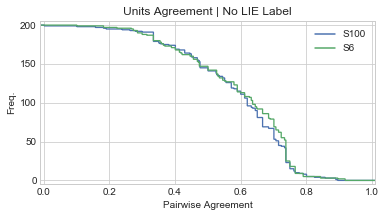

In [52]:
agreement('LIE')


,unit_id,position_in_task,doc_id,S100_rel,rel,S6_rel
0,unit_0,1,REP_LIE_doc6,3.0,LIE,1
1,unit_0,3,LOW,1.0,LOW,2
2,unit_0,4,DEM_HALFTRUE_doc3,2.0,HALFTRUE,4
3,unit_0,5,DEM_TRUE_doc2,40.0,TRUE,2
4,unit_0,6,HIGH,96.0,HIGH,6


0/200, 0/200, 

c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\barbe\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


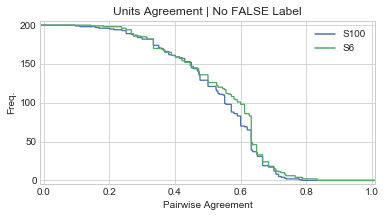

In [53]:
agreement('FALSE')

,unit_id,position_in_task,doc_id,S100_rel,rel,S6_rel
0,unit_0,1,REP_LIE_doc6,3.0,LIE,1
1,unit_0,2,DEM_FALSE_doc1,6.0,FALSE,1
2,unit_0,3,LOW,1.0,LOW,2
3,unit_0,4,DEM_HALFTRUE_doc3,2.0,HALFTRUE,4
4,unit_0,5,DEM_TRUE_doc2,40.0,TRUE,2


0/200, 0/200, 

c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\barbe\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


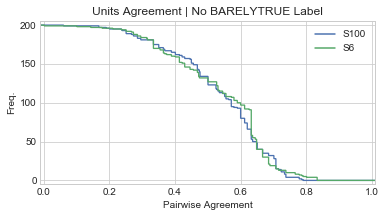

In [54]:
agreement('BARELYTRUE')

,unit_id,position_in_task,doc_id,S100_rel,rel,S6_rel
0,unit_0,1,REP_LIE_doc6,3.0,LIE,1
1,unit_0,2,DEM_FALSE_doc1,6.0,FALSE,1
2,unit_0,3,LOW,1.0,LOW,2
3,unit_0,5,DEM_TRUE_doc2,40.0,TRUE,2
4,unit_0,6,HIGH,96.0,HIGH,6


0/200, 0/200, 

c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\barbe\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


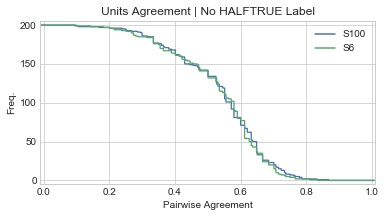

In [55]:
agreement('HALFTRUE')

,unit_id,position_in_task,doc_id,S100_rel,rel,S6_rel
0,unit_0,1,REP_LIE_doc6,3.0,LIE,1
1,unit_0,2,DEM_FALSE_doc1,6.0,FALSE,1
2,unit_0,3,LOW,1.0,LOW,2
3,unit_0,4,DEM_HALFTRUE_doc3,2.0,HALFTRUE,4
4,unit_0,5,DEM_TRUE_doc2,40.0,TRUE,2


0/200, 0/200, 

c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\barbe\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


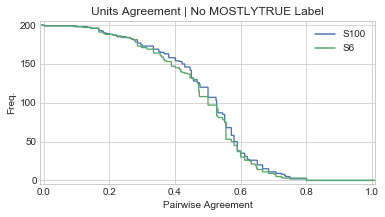

In [56]:
agreement('MOSTLYTRUE')

,unit_id,position_in_task,doc_id,S100_rel,rel,S6_rel
0,unit_0,1,REP_LIE_doc6,3.0,LIE,1
1,unit_0,2,DEM_FALSE_doc1,6.0,FALSE,1
2,unit_0,3,LOW,1.0,LOW,2
3,unit_0,4,DEM_HALFTRUE_doc3,2.0,HALFTRUE,4
4,unit_0,6,HIGH,96.0,HIGH,6


0/200, 0/200, 

c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\barbe\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


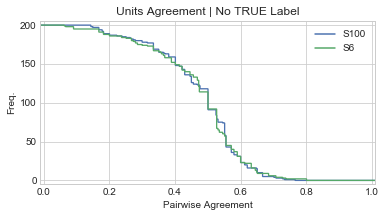

In [57]:
agreement('TRUE')

,unit_id,position_in_task,doc_id,S100_rel,rel,S6_rel
0,unit_0,1,REP_LIE_doc6,3.0,LIE,1
1,unit_0,2,DEM_FALSE_doc1,6.0,FALSE,1
2,unit_0,4,DEM_HALFTRUE_doc3,2.0,HALFTRUE,4
3,unit_0,5,DEM_TRUE_doc2,40.0,TRUE,2
4,unit_0,7,REP_MOSTLYTRUE_doc5,93.0,MOSTLYTRUE,5


0/200, 0/200, 

c:\users\barbe\anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\barbe\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


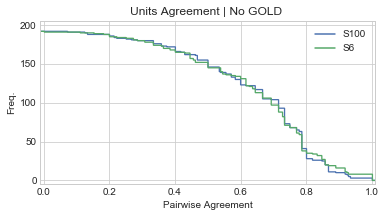

In [65]:
# AGREEMENT RIMUOVENDO HIGH E LOW
df_agreement = pd.DataFrame(columns=['unit', 'dataset', 'filtering', 'agr_measure', 'agr_score'])
dataset = "S100"
doc_rel = '{}_rel'.format(dataset)
df = pd.read_csv('../../Task/BigTask/Parsed-results_S100.csv')
df = df[df["rel"].isin(gold_dict) == False]
df100 = df[['unit_id', 'position_in_task', 'doc_id', "S100_rel", 'rel']]
dataset = 'S6'
doc_rel = '{}_rel'.format(dataset)
df= pd.read_csv('../../Task/BigTask/Parsed-results_S6.csv')
df = df[df["rel"].isin(gold_dict) == False]
df6 = df[['unit_id', 'position_in_task', 'doc_id', 'S6_rel']]
merged = df100.merge(df6, how = 'left', on = ['unit_id', 'position_in_task', 'doc_id'])
units = np.unique(merged['unit_id'].values)
display(merged.head())

for dataset_to_agreement in ['S100_rel', 'S6_rel']:
    for i_u, unit in enumerate(units): #   <-- for each unit
        if( (unit != 'unit_112') and (unit != 'unit_120') and (unit != 'unit_121') 
           and (unit != 'unit_124') and (unit != 'unit_125') and (unit != 'unit_151')
          and (unit != 'unit_179') and (unit != 'unit_53')):
            if i_u % 500 == 0: 
                print('{}/{}, '.format(i_u+1-1, len(units)), end='')
            pivoted = merged[merged['unit_id'] == unit]
            agr_ground_truth = pivoted['rel'].values
            agr_data = pivoted[dataset_to_agreement].values
            agremeent = my_pairw(agr_ground_truth, agr_data, which_group = 'first',
                                 agr_comparison='<', removeties=True)
            #'unit', 'dataset', 'filtering', 'agr_measure', 'agr_score'
            df_agreement.loc[len(df_agreement)] = np.array([unit, dataset_to_agreement, 'rel', 'pair_agree', agremeent])
df_agreement.set_index(['filtering', 'unit'], inplace = True)
#display(df_agreement.head())
datasets = ['S100_rel', 'S6_rel',]
filters = ['rel']

for filtering in filters :
    df_agreement_spec = df_agreement.loc[filtering]
    p_linestyles = ['-', '-', '-']
    p_colors = [sns.color_palette('deep')[0],sns.color_palette('deep')[1], sns.color_palette('deep')[2]]
    p_markers = ['o','D','^', 'o','D','^']
    pages = PdfPages("../../plots/BigTask/Units_Agreement/Agr_unitPairwise_with_{}_no_gold.pdf".format(filtering))
    plt.rcParams['figure.figsize']=(6,3)   

    for i,c in enumerate(datasets): 
        all_agr_sorted = df_agreement_spec[df_agreement_spec['dataset'] == c]
        all_agr_sorted['agr_score'] = all_agr_sorted['agr_score'].astype(float)
        n_bins = 1001
        lw = 1.3
        offs = .01
        ax =sns.distplot(all_agr_sorted['agr_score'], kde = False, 
                         bins = n_bins, norm_hist = False, label = c,
                               hist_kws = dict(cumulative = -1, 
                                               color = p_colors[i], 
                                               alpha = 1, 
                                               histtype = 'step', 
                                               linewidth = lw, 
                                               range = [-1-offs, 1+offs*2]))

    ax.set(title = "Units Agreement | No GOLD ", xlabel="Pairwise Agreement", ylabel = 'Freq.'.format())
    ax.set(xlim = (-0-offs, 1+offs))
    ax.set(ylim = (0-5-offs, 200+5+offs))
    # legend handles
    handles, labels = ax.get_legend_handles_labels()
    import matplotlib.lines as mlines
    cust = [   mlines.Line2D([], [], color = p_colors[i], marker = '', linestyle = p_linestyles[i],
                              markersize = 8, label = '1') for i in range(3) ]
    labels = ['S100', 'S6']
    ax.legend(cust, labels)
    pages.savefig(bbox_inches = 'tight');pages.close()
    plt.show()

In [106]:
df6 = pd.read_csv('../../Task/BigTask/Parsed-results_S6.csv')
df100 = pd.read_csv('../../Task/BigTask/Parsed-results_S100.csv')
df100.head(2)

,unit_id,doc_id,rel,worker_id,gender,age,school,income,party,party_ln,ideo,elections,teaparty,position_in_task,S100_rel,justification,url,off_page_count,ip_address,time
0,unit_0,REP_LIE_doc6,LIE,A28KV1QXL1AV4X,2,5,3,6,3,1,2,1,1,1,3.0,"Rick Perry was governor of Texas, not Massachu...",https://en.wikipedia.org/wiki/Rick_Perry,0,74.97.48.154,59.715
1,unit_0,DEM_FALSE_doc1,FALSE,A28KV1QXL1AV4X,2,5,3,6,3,1,2,1,1,2,6.0,Nancy Pelosi is House Majority leader and Spea...,https://www.facebook.com/NancyPelosi/,1,74.97.48.154,85.715


In [107]:
df100_anova = df100[['unit_id', 'gender', 'age', 'school', 'income', 'party', 'party_ln', 'ideo', 'elections', 'teaparty']]
df100_anova = df100_anova.drop_duplicates()
display(df100_anova.head(2))
df6_anova = df6[['unit_id', 'gender', 'age', 'school', 'income', 'party', 'party_ln', 'ideo', 'elections', 'teaparty']]
df6_anova = df6_anova.drop_duplicates()
display(df6_anova.head(2))

agree = df_agreement.reset_index()
agree.columns = ['filtering', 'unit_id', 'dataset', 'agr_measure', 'agr_score']

agree_S100 = agree[agree['dataset'] == 'S100_rel']
agree_S6 = agree[agree['dataset'] == 'S6_rel']

merged_S100 = pd.merge(df100_anova, agree_S100, how = 'inner', on = 'unit_id')
merged_S100 = merged_S100[['unit_id', 'gender', 'age', 'school', 'income', 'party', 'party_ln', 'ideo', 'elections', 'teaparty', 'agr_score']]
display(merged_S100.head())
merged_S6 = pd.merge(df6_anova, agree_S6, how = 'inner', on = 'unit_id')
merged_S6 = merged_S6[['unit_id', 'gender', 'age', 'school', 'income', 'party', 'party_ln', 'ideo', 'elections', 'teaparty', 'agr_score']]
display(merged_S6.head())

,unit_id,gender,age,school,income,party,party_ln,ideo,elections,teaparty
0,unit_0,2,5,3,6,3,1,2,1,1
8,unit_1,1,3,6,9,1,1,2,1,1


,unit_id,gender,age,school,income,party,party_ln,ideo,elections,teaparty
0,unit_0,2,3,4,3,2,2,4,1,3
8,unit_1,2,3,5,7,3,1,4,1,1


,unit_id,gender,age,school,income,party,party_ln,ideo,elections,teaparty,agr_score
0,unit_0,2,5,3,6,3,1,2,1,1,0.4642857142857143
1,unit_1,1,3,6,9,1,1,2,1,1,0.6153846153846154
2,unit_2,1,4,3,9,1,1,2,1,1,0.42857142857142855
3,unit_3,1,4,4,6,3,2,3,1,2,0.6296296296296297
4,unit_4,1,3,4,7,3,2,4,1,1,0.4090909090909091


,unit_id,gender,age,school,income,party,party_ln,ideo,elections,teaparty,agr_score
0,unit_0,2,3,4,3,2,2,4,1,3,0.52
1,unit_1,2,3,5,7,3,1,4,1,1,0.47368421052631576
2,unit_2,1,4,4,7,4,2,3,1,3,0.11764705882352941
3,unit_3,1,3,6,9,1,1,1,1,1,0.64
4,unit_4,1,4,3,8,3,2,3,1,1,0.7083333333333334


In [108]:
# Gender
merged_S100['gender'] = merged_S100['gender'].map({1 : "Male", 2 : "Female", 3 : "Other"})
merged_S6['gender'] = merged_S6['gender'].map({1 : "Male", 2 : "Female", 3 : "Other"})
# Age
merged_S100['age'] = merged_S100['age'].map({1 : "0-18", 2 : "19-25", 3 : "26-35", 4 : "36-50", 5 : "50-80", 6 : ">80"})
merged_S6['age'] = merged_S6['age'].map({1 : "0-18", 2 : "19-25", 3 : "26-35", 4 : "36-50", 5 : "50-80", 6 : ">80"})
# School
merged_S100['school'] = merged_S100['school'].map({1 : "Incomplete", 2 : "HighSchool", 3 : "College", 4 : "BachelorsDegree", 5 : "Postgraduate", 6 : "Master"})
merged_S6['school'] = merged_S6['school'].map({1 : "Incomplete", 2 : "HighSchool", 3 : "College", 4 : "BachelorsDegree", 5 : "Postgraduate", 6 : "Master"})
# Income
merged_S100['income'] = merged_S100['income'].map({1 : "<10.000$", 2 : "10.000$<20.000$", 3 : "20.000$<30.000$", 4 : "30.000$<40.000$",
                                                   5 : "40.000$<50.000$", 6 : "50.000$<75.000$", 7 : "75.000$<100.000$", 8 : "100.000$<150.000$", 9 : ">150.000$"})
merged_S6['income'] = merged_S6['income'].map({1 : "<10.000$", 2 : "10.000$<20.000$", 3 : "20.000$<30.000$", 4 : "30.000$<40.000$",
                                                   5 : "40.000$<50.000$", 6 : "50.000$<75.000$", 7 : "75.000$<100.000$", 8 : "100.000$<150.000$", 9 : ">150.000$"})
# Party
merged_S100['party'] = merged_S100['party'].map({1 : "Republican", 2 : "Democrat", 3 : "Indipendent", 4 : "Other"})
merged_S6['party'] = merged_S6['party'].map({1 : "Republican", 2 : "Democrat", 3 : "Indipendent", 4 : "Other"})
# Party Alignment
merged_S100['party_ln'] = merged_S100['party_ln'].map({1 : "RepublicanParty", 2 : "DemocratParty"})
merged_S6['party_ln'] = merged_S6['party_ln'].map({1 : "RepublicanParty", 2 : "DemocratParty"})
# Ideo
merged_S100['ideo'] = merged_S100['ideo'].map({1 : "VeryConservative", 2 : "Conservative", 3 : "Moderate", 4 : "Liberal", 5 : "VeryLiberal"})
merged_S6['ideo'] = merged_S6['ideo'].map({1 : "VeryConservative", 2 : "Conservative", 3 : "Moderate", 4 : "Liberal", 5 : "VeryLiberal"})
# Elections
merged_S100['elections'] = merged_S100['elections'].map({1 : "Yes", 2 : "No", 3 : "NoAnswer"})
merged_S6['elections'] = merged_S6['elections'].map({1 : "Yes", 2 : "No", 3 : "NoAnswer"})
# Tea Party
merged_S100['teaparty'] = merged_S100['teaparty'].map({1 : "Agree", 2 : "Disagree", 3 : "NoOpinion"})
merged_S6['teaparty'] = merged_S6['teaparty'].map({1 : "Agree", 2 : "Disagree", 3 : "NoOpinion"})

display(merged_S100.head())
display(merged_S6.head())

,unit_id,gender,age,school,income,party,party_ln,ideo,elections,teaparty,agr_score
0,unit_0,Female,50-80,College,50.000$<75.000$,Indipendent,RepublicanParty,Conservative,Yes,Agree,0.4642857142857143
1,unit_1,Male,26-35,Master,>150.000$,Republican,RepublicanParty,Conservative,Yes,Agree,0.6153846153846154
2,unit_2,Male,36-50,College,>150.000$,Republican,RepublicanParty,Conservative,Yes,Agree,0.42857142857142855
3,unit_3,Male,36-50,BachelorsDegree,50.000$<75.000$,Indipendent,DemocratParty,Moderate,Yes,Disagree,0.6296296296296297
4,unit_4,Male,26-35,BachelorsDegree,75.000$<100.000$,Indipendent,DemocratParty,Liberal,Yes,Agree,0.4090909090909091


,unit_id,gender,age,school,income,party,party_ln,ideo,elections,teaparty,agr_score
0,unit_0,Female,26-35,BachelorsDegree,20.000$<30.000$,Democrat,DemocratParty,Liberal,Yes,NoOpinion,0.52
1,unit_1,Female,26-35,Postgraduate,75.000$<100.000$,Indipendent,RepublicanParty,Liberal,Yes,Agree,0.47368421052631576
2,unit_2,Male,36-50,BachelorsDegree,75.000$<100.000$,Other,DemocratParty,Moderate,Yes,NoOpinion,0.11764705882352941
3,unit_3,Male,26-35,Master,>150.000$,Republican,RepublicanParty,VeryConservative,Yes,Agree,0.64
4,unit_4,Male,36-50,College,100.000$<150.000$,Indipendent,DemocratParty,Moderate,Yes,Agree,0.7083333333333334


In [109]:
# Tempi
df6 = pd.read_csv('../../Task/BigTask/Parsed-results_S6.csv')
df100 = pd.read_csv('../../Task/BigTask/Parsed-results_S100.csv')

df6_time = df6[['unit_id', 'time']]
df100_time = df100[['unit_id','time']]

df6_time = df6_time.groupby(['unit_id']).agg('mean').reset_index()
df100_time = df100_time.groupby(['unit_id']).agg('mean').reset_index()

merged_S6 = pd.merge(merged_S6, df6_time, how = 'inner', on = 'unit_id')
merged_S100 = pd.merge(merged_S100, df100_time, how = 'inner', on = 'unit_id')

display(merged_S100.head(2))
merged_S100.to_csv("../../Task/BigTask/anova_data_S100.csv", index=False, header=True)
merged_S6.to_csv("../../Task/BigTask/anova_data_S6.csv", index=False, header=True)

,unit_id,gender,age,school,income,party,party_ln,ideo,elections,teaparty,agr_score,time
0,unit_0,Female,50-80,College,50.000$<75.000$,Indipendent,RepublicanParty,Conservative,Yes,Agree,0.4642857142857143,129.216000
1,unit_1,Male,26-35,Master,>150.000$,Republican,RepublicanParty,Conservative,Yes,Agree,0.6153846153846154,16.935875


In [97]:
df_agreement_rep = pd.DataFrame(columns=['unit', 'dataset', 'filtering', 'agr_measure', 'agr_score'])
df_agreement_dem = pd.DataFrame(columns=['unit', 'dataset', 'filtering', 'agr_measure', 'agr_score'])


dataset = "S100"
doc_rel = '{}_rel'.format(dataset)
df = pd.read_csv('../../Task/BigTask/Parsed-results_S100.csv')
df = df[df["rel"].isin(gold_dict) == False]
df100 = df[['unit_id', 'position_in_task', 'doc_id', "S100_rel", 'rel']]
df = df[df["rel"].isin(gold_dict) == False]

dataset = 'S6'
doc_rel = '{}_rel'.format(dataset)
df = pd.read_csv('../../Task/BigTask/Parsed-results_S6.csv')
df = df[df["rel"].isin(gold_dict) == False]
df6 = df[['unit_id', 'position_in_task', 'doc_id', 'S6_rel']]

merged = df100.merge(df6, how = 'left', on = ['unit_id', 'position_in_task', 'doc_id'])

#merged = merged[merged[filtering]>=0]

#display(merged.head(2))
############################################

units = np.unique(merged['unit_id'].values)

# Prendo i party
merged['party'] = ''
merged['party'] = merged.apply(lambda row: row.doc_id.split('_')[0], axis = 1)

merged_rep = merged[merged['party'] == 'REP']
#merged_rep = merged_rep[merged_rep.unit_id != 'unit_112']
merged_dem = merged[merged['party'] == 'DEM']

#assert False
for dataset_to_agreement in ['S100_rel', 'S6_rel']:
    for i_u, unit in enumerate(units): #   <-- for each unit
        #display(unit)
        #if((unit != 'unit_112') and (unit != 'unit_120') and (unit != 'unit_121') and (unit != 'unit_124')
        #  and (unit != 'unit_167') and (unit != 'unit_177') and (unit != 'unit_197') and (unit != 'unit_20')):
        if i_u % 500 == 0: 
            print('{}/{}, '.format(i_u+1-1, len(units)), end='')
        pivoted = merged_rep[merged_rep['unit_id'] == unit]
        agr_ground_truth = pivoted['rel'].values
        agr_data = pivoted[dataset_to_agreement].values

        #display(agr_data)
        agremeent = my_pairw(agr_ground_truth, agr_data, which_group = 'first',
                             agr_comparison='<', removeties=False)
        #'unit', 'dataset', 'filtering', 'agr_measure', 'agr_score'
        df_agreement_rep.loc[len(df_agreement_rep)] = np.array([unit, dataset_to_agreement, 'rel', 'pair_agree', agremeent])

df_agreement_rep.set_index(['filtering', 'unit'], inplace = True)
display(df_agreement_rep.head(2))

for dataset_to_agreement in ['S100_rel', 'S6_rel']:
    for i_u, unit in enumerate(units): #   <-- for each unit
        
        if i_u % 500 == 0: 
            print('{}/{}, '.format(i_u+1-1, len(units)), end='')
        pivoted = merged_dem[merged_dem['unit_id'] == unit]
        agr_ground_truth = pivoted['rel'].values
        agr_data = pivoted[dataset_to_agreement].values
        
        #display(agr_data)
        agremeent = my_pairw(agr_ground_truth, agr_data, which_group = 'first',
                             agr_comparison='<', removeties=False)
        #'unit', 'dataset', 'filtering', 'agr_measure', 'agr_score'
        df_agreement_dem.loc[len(df_agreement_dem)] = np.array([unit, dataset_to_agreement, 'rel', 'pair_agree', agremeent])

df_agreement_dem.set_index(['filtering', 'unit'], inplace = True)
display(df_agreement_dem.head(2))

0/200, 0/200, 

dataset agr_measure           agr_score
filtering unit                                            
rel       unit_0  S100_rel  pair_agree  0.6666666666666666
          unit_1  S100_rel  pair_agree                 1.0

0/200, 0/200, 

dataset agr_measure           agr_score
filtering unit                                            
rel       unit_0  S100_rel  pair_agree  0.6666666666666666
          unit_1  S100_rel  pair_agree  0.6666666666666666

In [98]:
agree = df_agreement_dem.reset_index()
agree.columns = ['filtering', 'unit_id', 'dataset', 'agr_measure', 'agr_score_dem']
agree_S100 = agree[agree['dataset'] == 'S100_rel']
agree_S6 = agree[agree['dataset'] == 'S6_rel']
merged_S100 = pd.merge(merged_S100, agree_S100, how = 'inner', on = 'unit_id')
merged_S6 = pd.merge(merged_S6, agree_S6, how = 'inner', on = 'unit_id')
display(merged_S100.head())

agree = df_agreement_rep.reset_index()
agree.columns = ['filtering', 'unit_id', 'dataset', 'agr_measure', 'agr_score_rep']
agree_S100 = agree[agree['dataset'] == 'S100_rel']
agree_S6 = agree[agree['dataset'] == 'S6_rel']
merged_S100 = pd.merge(merged_S100, agree_S100, how = 'inner', on = 'unit_id')
merged_S6 = pd.merge(merged_S6, agree_S6, how = 'inner', on = 'unit_id')

,unit_id,gender,age,school,income,party,party_ln,ideo,elections,teaparty,agr_score,time,filtering,dataset,agr_measure,agr_score_dem
0,unit_0,Female,50-80,College,50.000$<75.000$,Indipendent,RepublicanParty,Conservative,Yes,Agree,0.4642857142857143,129.216000,rel,S100_rel,pair_agree,0.6666666666666666
1,unit_1,Male,26-35,Master,>150.000$,Republican,RepublicanParty,Conservative,Yes,Agree,0.6153846153846154,16.935875,rel,S100_rel,pair_agree,0.6666666666666666
2,unit_2,Male,36-50,College,>150.000$,Republican,RepublicanParty,Conservative,Yes,Agree,0.42857142857142855,56.906125,rel,S100_rel,pair_agree,0.0
3,unit_3,Male,36-50,BachelorsDegree,50.000$<75.000$,Indipendent,DemocratParty,Moderate,Yes,Disagree,0.6296296296296297,133.531500,rel,S100_rel,pair_agree,0.6666666666666666
4,unit_4,Male,26-35,BachelorsDegree,75.000$<100.000$,Indipendent,DemocratParty,Liberal,Yes,Agree,0.4090909090909091,220.102625,rel,S100_rel,pair_agree,0.0


In [100]:
display(merged_S100.head())

,unit_id,gender,age,school,income,party,party_ln,ideo,elections,teaparty,agr_score,time,filtering_x,dataset_x,agr_measure_x,agr_score_dem,filtering_y,dataset_y,agr_measure_y,agr_score_rep
0,unit_0,Female,50-80,College,50.000$<75.000$,Indipendent,RepublicanParty,Conservative,Yes,Agree,0.4642857142857143,129.216000,rel,S100_rel,pair_agree,0.6666666666666666,rel,S100_rel,pair_agree,0.6666666666666666
1,unit_1,Male,26-35,Master,>150.000$,Republican,RepublicanParty,Conservative,Yes,Agree,0.6153846153846154,16.935875,rel,S100_rel,pair_agree,0.6666666666666666,rel,S100_rel,pair_agree,1.0
2,unit_2,Male,36-50,College,>150.000$,Republican,RepublicanParty,Conservative,Yes,Agree,0.42857142857142855,56.906125,rel,S100_rel,pair_agree,0.0,rel,S100_rel,pair_agree,0.6666666666666666
3,unit_3,Male,36-50,BachelorsDegree,50.000$<75.000$,Indipendent,DemocratParty,Moderate,Yes,Disagree,0.6296296296296297,133.531500,rel,S100_rel,pair_agree,0.6666666666666666,rel,S100_rel,pair_agree,0.6666666666666666
4,unit_4,Male,26-35,BachelorsDegree,75.000$<100.000$,Indipendent,DemocratParty,Liberal,Yes,Agree,0.4090909090909091,220.102625,rel,S100_rel,pair_agree,0.0,rel,S100_rel,pair_agree,1.0


In [99]:
merged_S100.to_csv("../../Task/BigTask/anova_data_S100.csv", index=False, header=True)
merged_S6.to_csv("../../Task/BigTask/anova_data_S6.csv", index=False, header=True)